In [35]:
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import glob
import os
import cv2

from skimage.io import imread, imshow
from skimage.transform import resize
from matplotlib import gridspec
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Lambda, Input, MaxPool2D, UpSampling2D, Flatten, Dense, Conv2DTranspose, Reshape, Dropout, BatchNormalization, GlobalMaxPooling2D
# from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import KLDivergence
from tensorflow.keras.losses import binary_crossentropy, mse
from tensorflow.keras.applications import EfficientNetB0

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, ReduceLROnPlateau

from tensorboard.plugins.hparams import api as hp
from tensorflow.keras import backend as K

%matplotlib inline

In [2]:
len(tf.config.experimental.list_physical_devices('GPU'))

1

In [3]:
tf.__version__

'2.3.0'

#  Image classification and autoencoders

## Implementing classification with CNN, Denoising Convolutional Autoencoder and Variational Autoencoder with Tensorflow 2.3

### Author: AnaStasiaS-S
### Summary

The purpose of this project is to get familiar with the first principles of Deep Learning for developing a solid knowledge ground. The project is split into three parts and includes various technics for achieving the set goals.

**@ Dancho**, we met twice last year on exams of Data Science 2019 and ML 2019. I'm that blond girl which is used to cry on exams :D I thought I do not need Deep Learning in 2019, but I was lying myself. For a few months I've been participated self-driving cars project  (mine main tasks were features engineering, cars sensors decoding, etc.), which was followed by a few other EDA and DS projects on different subjects, and finally, this year I've realized that I want to get familiar with Deep Learning :)

### Introduction

For the purposes of this research I put a goal to start from scratch by solving Convolutional Neural network classification problem with my own efforts and then compare it with transfer learning approach. For transfer learning I chose EfficientNet-B0.

Afterwards I've created Denoising Convolutional Autoencoder where I've actually started meeting first difficulties with model training. And finally, I've made an attempt to create a Variational Autoencoder following some resources and publications on Internet. The latter experience wasn't successful but now I can tell why.

# 1. 3-class classification problem

## 1.1. Convolutional neural network from scratch

### 1.1.1. Read the data

I used a dataset from [Kaggle](https://www.kaggle.com/alessiocorrado99/animals10?select=raw-img) with three classes (YES, it is about CATS and DOGS, but I've also added CHICKEN to make problem more complex). The original dataset contains 10 classes which were reduced to 3 because of a very long training time (I had an attempt to perform 10 classes training first). Each class contains 3-4K images. 

For splitting labels to train/val/test, I've used split_folders library.

In [2]:
# %ls '/content/gdrive/My Drive/Colab Notebooks/PROJECT/data/train'

In [ ]:
# split to train/val/test
# pip install split_folders
# import splitfolders
# input_folder = "/content/gdrive/My Drive/Colab Notebooks/PROJECT/data_3_classes/"
# output = "/content/gdrive/My Drive/Colab Notebooks/PROJECT/data_3_classes_split/"
# splitfolders.ratio(input_folder, output, ratio=(.8, .1, .1))

In [4]:
PATH = './data/'
train_dir = os.path.join(PATH, 'train')
val_dir = os.path.join(PATH, 'val')
test_dir = os.path.join(PATH, 'test')

train_size = len(glob.glob(train_dir + '/*/*'))
test_size = len(glob.glob(test_dir + '/*/*'))
val_size = len(glob.glob(val_dir + '/*/*'))

print("Train size:", train_size)
print("Test size:", test_size)
print("Val size: ", val_size)

Train size: 9403
Test size: 1178
Val size:  1174


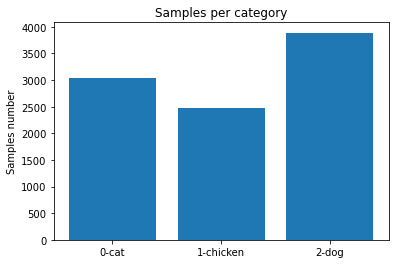

In [6]:
# number samples per category. The dataset is imbalansed.
categories = []
for i, path in enumerate(glob.glob(train_dir + '/*')):
    categories.append(len(glob.glob(path + "/*")))
  # print(path, categories)

plt.bar(["0-cat", "1-chicken", "2-dog"], height=categories)
# plt.xlabel('Categories')
plt.ylabel('Samples number')
plt.title("Samples per category")
plt.show()

### 1.1.2 Data augmentation for train dataset

As we have only 2500 images for one of the classes, for better results the good approach would be to use data augmentation where I rescale the images by dividing them by 255 pixels. The image size is 128x128 in order to speed up training time. Also I've added flow_from_directory method to simplify data batch generation .

In [7]:
# some constants
IMG_SHAPE = (128, 128)
BATCH_SIZE = 32

# use data augmentation + data generator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

# Don't apply any transformations to the validation data
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1. / 255)

# loss function определя какво ше правим
# binary_crossentropy - за 2 категории
# sparse_categorical_crossentropy - за много категории в цифри (0, 1, 2, 3.., 10 за нашия пример) т.е. в оригиналния формат
# categorical_crossentropy - за OneHot encoded labels

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=IMG_SHAPE,
        batch_size=BATCH_SIZE,
        class_mode='sparse')

validation_generator = val_datagen.flow_from_directory(
        val_dir,
        target_size=IMG_SHAPE,
        batch_size=BATCH_SIZE,
        class_mode='sparse')

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SHAPE,
    batch_size=BATCH_SIZE,
    # class_mode='categorical',
    class_mode='sparse',
    shuffle=True)

Found 9403 images belonging to 3 classes.
Found 1174 images belonging to 3 classes.
Found 1178 images belonging to 3 classes.


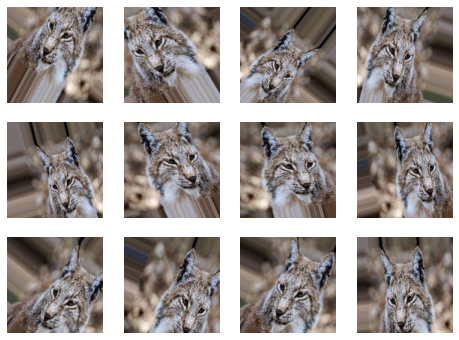

In [8]:
# Example of augmented images
augmented_images = [train_generator[0][0][1] for i in range(12)]
plt.figure(figsize=(8,6))

for i in range(12):
    plt.subplot(3, 4, i+1)
    image = augmented_images[i]
    plt.imshow(image)
    plt.axis('off')
plt.show()

Total number of batches: 294
Batch shape: (32, 128, 128, 3) (32,)
Image shape: (128, 128, 3)
Label: 0


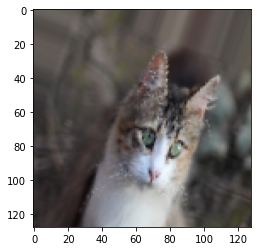

In [9]:
# this are the shapes of images in a batch
batch=next(train_generator)  # returns the next batch of images and labels 

print("Total number of batches:", (round(train_size/BATCH_SIZE))) # ImageDataGenerator produces this number different augmented image series
print("Batch shape:", batch[0].shape, batch[1].shape) # batch[0] is the images, batch[1] are the labels
img=batch[0][0]   # this is the first image  batch[0][1] would be the next image
img_label=batch[1][0]   # this is the first label  
print("Image shape:", img.shape)
plt.imshow(img)   # shows the first image
print("Label:", img_label.astype(int))

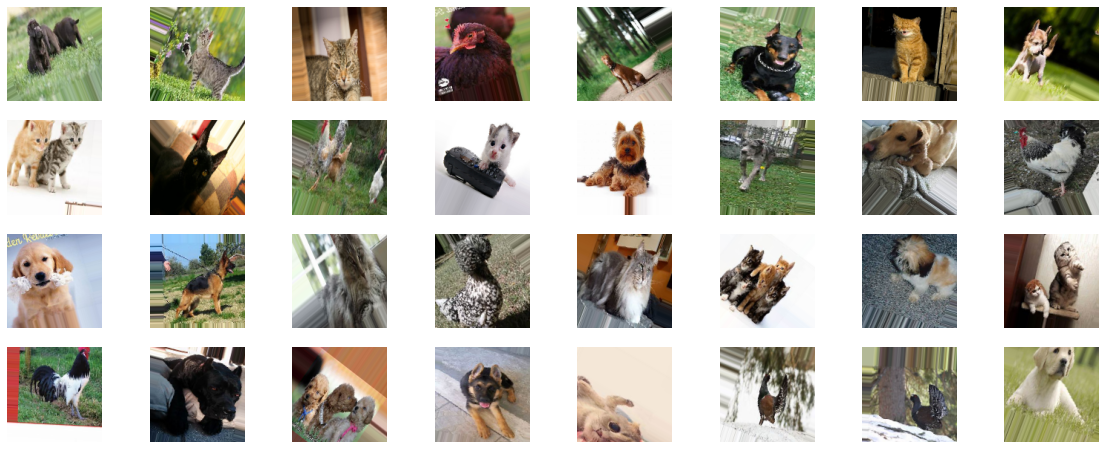

In [11]:
# this is how one train batch looks like: it contains random augmented images
plt.figure(figsize=(20,8)) 
for (i, image) in enumerate(batch[0]):
    # print(i)
    plt.subplot(4,8,i+1)    # the number of images in the grid is 4*8 (as we have 32 images per batch)
    plt.imshow(image)
    plt.axis('off')

plt.show()

In [2]:
def plot_metrics_accuracy(history):
    # list all data in history
    print(history.history.keys())
    # summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    
def plot_metrics_loss(history):
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()    

def plot_loss_with_learning_rate(history):
    plt.figure()
    gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1]) 
    ax1 = plt.subplot(gs[0])
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.ylim(300, 1000)
    plt.legend()
    ax2 = plt.subplot(gs[1])
    plt.plot(history.history['lr'], label='lr')
    plt.legend()
    ax2.set_xlabel('epoch')
    ax2.set_yscale('log')
    plt.tight_layout()
    
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = tf.image.resize(img, (128, 128))
        img_new = img.numpy()/255.0 # rescale
        images.append(img_new)
        
    images = np.array(images)
    return(images)

In [ ]:
# some callbacks used in this notebook: tensorboard, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

log_dir = "./logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
models_dir = "./models/best_model.h5"

tb_cb = TensorBoard(
    log_dir=log_dir, 
    profile_batch=0)

es_cb = EarlyStopping(
    monitor='val_loss',
    verbose=True,
    patience=5,
    min_delta=0.0001, 
    restore_best_weights=True)

lr_cb = ReduceLROnPlateau(
    monitor='val_loss',
    verbose=True,
    patience=3,
    mi_delta=0.0001)

mc_mse_cb = ModelCheckpoint(
    models_dir,
    monitor='val_loss', 
    mode='min', 
    verbose=1, 
    save_best_only=True)

mc_acc_cb = ModelCheckpoint(
    models_dir, 
    monitor='val_accuracy', 
    mode='max', 
    verbose=1, 
    save_best_only=True)

### 1.1.3 Define and train base CNN architecture and train the model

For this model I used 3 channel images of 128x128 size. CNN architecture includes 5 convolutional layers with normalization and dimensional reduction after each using max pooling. I've played with different type and depth architectures but even deeper networks didn't obtain better accuracy results.

In [13]:
neural_network = Sequential([    
    
    Input((IMG_SHAPE[0], IMG_SHAPE[1], 3)),
    
    Conv2D(filters = 32, kernel_size = 5, padding = "same", activation = "relu"), # padding will add 2px frame
    BatchNormalization(),
    MaxPool2D(),
    
    Conv2D(filters = 32, kernel_size = 5, padding = "same", activation = "relu"), # padding will add 2px frame
    BatchNormalization(),    
    MaxPool2D(),
    
    Conv2D(filters = 32, kernel_size = 3, padding = "same", activation = "relu"), # padding will add 1px frame
    BatchNormalization(),    
    MaxPool2D(),
    
    Conv2D(filters = 64, kernel_size = 3, padding = "same", activation = "relu"),
    BatchNormalization(),    
    MaxPool2D(),
    
    Conv2D(filters = 128, kernel_size = 3, padding = "same", activation = "relu"),
    
    Flatten(),    
    Dropout(0.5),
    BatchNormalization(), 

    Dense(512, activation='relu'),    
    Dropout(0.1),
    
    Dense(256, activation='relu'),    
    Dropout(0.1),

    Dense(128, activation='relu'),    
    Dropout(0.05),
    
    Dense(3, activation='softmax')
])

neural_network.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 32)      2432      
_________________________________________________________________
batch_normalization (BatchNo (None, 128, 128, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 32)        25632     
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 64, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        9

Epoch 1/30
  1/293 [..............................] - ETA: 0s - loss: 1.7495 - accuracy: 0.3125WARNING:tensorflow:From D:\Nastya\envs\tf-env\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
294/293 [==============================] - ETA: 0s - loss: 0.9923 - accuracy: 0.5092
Epoch 00001: val_accuracy improved from -inf to 0.42760, saving model to models\best_model_65М_parameters.h5
294/293 [==============================] - 59s 200ms/step - loss: 0.9923 - accuracy: 0.5092 - val_loss: 1.2457 - val_accuracy: 0.4276
Epoch 2/30
294/293 [==============================] - ETA: 0s - loss: 0.8657 - accuracy: 0.5809
Epoch 00002: val_accuracy did not improve from 0.42760
294/293 [==============================] - 58s 198ms/step - loss: 0.8657 - accuracy: 0.5809 - val_loss: 2.0920 - val_accuracy: 0.4250
Epoch 3/30
29

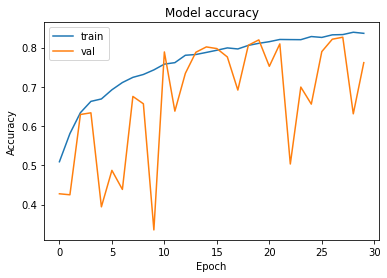

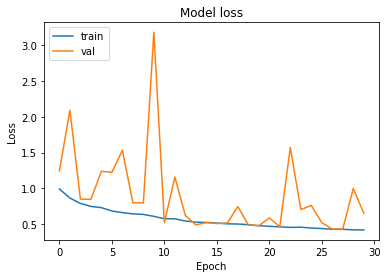

In [18]:
neural_network.compile(
    optimizer=Adam(learning_rate = 0.001) , 
    loss='sparse_categorical_crossentropy', 
    metrics = ['accuracy']
)

history = neural_network.fit(        
    train_generator,
    epochs = 30,
    validation_data=validation_generator,
    steps_per_epoch = train_size/BATCH_SIZE,
    callbacks = [es_cb, mc_acc_cb] 
)

plot_metrics_accuracy(history)
plot_metrics_loss(history)

### 1.1.4 Model hyperparameter Tuning with the HParams Dashboard

The base model training performed with 0.82 accuracy. Now I will try to hypertune three parameters in this model using HParams Dashboard tool. I will Experiment with three hyperparameters in the model:
* Learning rate
* Number of units in the first dense layer
* Dropout rate after the first dense layer

In [14]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [16]:
# some hyperparameter values to play with
HP_LR = hp.HParam('learning_rate', hp.RealInterval(0.0001, 0.001))
HP_NUM_UNITS = hp.HParam('num_units', hp.Discrete([256, 512]))
HP_DROPOUT = hp.HParam('dropout', hp.RealInterval(0.5, 0.7))

METRIC_ACCURACY = 'accuracy'

In [17]:
# create a new derictory for writing the results 
with tf.summary.create_file_writer('logs/hparam_tuning').as_default():
    hp.hparams_config(
    hparams=[HP_NUM_UNITS, HP_DROPOUT, HP_LR],
    metrics=[hp.Metric(METRIC_ACCURACY, display_name='Accuracy')],
  )

In [18]:
def train_test_model(hparams, run_dir, callbacks):
    neural_network = Sequential([    
        Input((IMG_SHAPE[0], IMG_SHAPE[1], 3)),
    
        Conv2D(filters = 32, kernel_size = 5, padding = "same", activation = "relu"), # padding will add 2px frame
        BatchNormalization(),    
        MaxPool2D(),
    
        Conv2D(filters = 32, kernel_size = 3, padding = "same", activation = "relu"), # padding will add 2px frame
        BatchNormalization(),    
        MaxPool2D(),
    
        Conv2D(filters = 64, kernel_size = 3, padding = "same", activation = "relu"), # padding will add 1px frame
        BatchNormalization(),    
        MaxPool2D(),
    
        Conv2D(filters = 64, kernel_size = 3, padding = "same", activation = "relu"),
        BatchNormalization(),    
        MaxPool2D(),
    
        Conv2D(filters = 128, kernel_size = 3, padding = "same", activation = "relu"),
        BatchNormalization(),    
        MaxPool2D(),
    
        Flatten(),    
        Dropout(hparams[HP_DROPOUT]), # <- hypertune Dropout rate here
        BatchNormalization(), 

        Dense(hparams[HP_NUM_UNITS], activation='relu'),    # <- hypertune number of units in this fully connected layer
        Dropout(0.3),
    
        Dense(256, activation='relu'),    
        Dropout(0.1),

        Dense(128, activation='relu'),    
        Dropout(0.05),
    
        Dense(3, activation='softmax')
      ])
    
    neural_network.compile(
        optimizer=Adam(learning_rate = hparams[HP_LR]) , # <- tune learning rate
        loss='sparse_categorical_crossentropy',
        metrics = ['accuracy']
    )

    neural_network.fit(
        train_generator,
        epochs = 30,
        validation_data=validation_generator,
        validation_steps=val_size / BATCH_SIZE,
        steps_per_epoch = train_size/BATCH_SIZE,
        callbacks = callbacks
    )
    
#     saved_model = tf.keras.models.load_model(os.path.join(run_dir+'/best_model_from_scratch.h5'))
    _, test_acc = neural_network.evaluate(test_generator, verbose=1)
    return test_acc

In [19]:
def run(run_dir, hparams):
    with tf.summary.create_file_writer(run_dir).as_default():
        hp.hparams(hparams)  # record the values set in HP
        accuracy = train_test_model(hparams, run_dir)
        tf.summary.scalar(METRIC_ACCURACY, accuracy, step=1)

In [24]:
session_num = 0
for num_units in HP_NUM_UNITS.domain.values:
    for dropout_rate in (HP_DROPOUT.domain.min_value, HP_DROPOUT.domain.max_value):
        for learning_rate in (HP_LR.domain.min_value, HP_LR.domain.max_value):
            hparams = {
                HP_NUM_UNITS: num_units,
                HP_DROPOUT: dropout_rate,
                HP_LR: learning_rate
            }
            # print(hparams)
            run_name = "run-%d" % session_num
            print('--- Starting trial: %s' % run_name)
            print({h.name: hparams[h] for h in hparams})
            run(('logs/hparam_tuning/' + run_name), hparams)
            session_num += 1

--- Starting trial: run-0
{'num_units': 256, 'dropout': 0.5, 'learning_rate': 0.0001}
Epoch 1/30
294/293 [==============================] - 58s 198ms/step - loss: 1.0439 - accuracy: 0.4606 - val_loss: 1.1782 - val_accuracy: 0.3245
Epoch 2/30
294/293 [==============================] - 58s 197ms/step - loss: 0.9348 - accuracy: 0.5394 - val_loss: 0.9073 - val_accuracy: 0.5426
Epoch 3/30
294/293 [==============================] - 58s 197ms/step - loss: 0.8851 - accuracy: 0.5747 - val_loss: 1.1964 - val_accuracy: 0.4463
Epoch 4/30
294/293 [==============================] - 58s 197ms/step - loss: 0.8602 - accuracy: 0.5922 - val_loss: 1.4063 - val_accuracy: 0.3910
Epoch 5/30
294/293 [==============================] - 58s 197ms/step - loss: 0.8135 - accuracy: 0.6220 - val_loss: 1.1180 - val_accuracy: 0.4881
Epoch 6/30
294/293 [==============================] - 58s 197ms/step - loss: 0.7937 - accuracy: 0.6365 - val_loss: 0.8921 - val_accuracy: 0.5997
Epoch 7/30
294/293 [========================

294/293 [==============================] - 58s 197ms/step - loss: 0.7754 - accuracy: 0.6453 - val_loss: 0.9928 - val_accuracy: 0.5622
Epoch 4/30
294/293 [==============================] - 58s 197ms/step - loss: 0.7323 - accuracy: 0.6778 - val_loss: 0.9594 - val_accuracy: 0.5707
Epoch 5/30
294/293 [==============================] - 58s 197ms/step - loss: 0.6796 - accuracy: 0.6992 - val_loss: 0.6894 - val_accuracy: 0.6934
Epoch 6/30
294/293 [==============================] - 58s 197ms/step - loss: 0.6474 - accuracy: 0.7234 - val_loss: 0.6268 - val_accuracy: 0.7232
Epoch 7/30
294/293 [==============================] - 58s 197ms/step - loss: 0.6135 - accuracy: 0.7370 - val_loss: 0.6060 - val_accuracy: 0.7504
Epoch 8/30
294/293 [==============================] - 58s 197ms/step - loss: 0.5907 - accuracy: 0.7541 - val_loss: 0.5702 - val_accuracy: 0.7572
Epoch 9/30
294/293 [==============================] - 58s 196ms/step - loss: 0.5770 - accuracy: 0.7587 - val_loss: 0.6937 - val_accuracy: 0.6

As presenting Tensorflow in Jupyter notebook is available in Google Colab but I didn't have this convinient feature when training on GPU, I've made a screenshot with the results. As seen, the best accuracy score is obtained using 512 units in Dense layer, 0.5 DropOut rate and 0.001 learning rate. 

From numerous tests of my base model I was lucky to use the same parameters in not tuned base model as well, so **the result of base model from scratch is almost the same - accuracy is 0.82**. 

The more interesting thing is how different accuracy is (sometimes it is double less) using different hyperparameters. 

Using Tensorboard is a convinient way to represent hyperparameter tuning, however I used GridSearch which iterates through all the given hyperparameters. For speeding up fine tuning of a larger number of parameters, the better way would be to use Random Search where the values will be picked up randomly.

![a](Tensorboard_tuned_model_from_scracth.JPG "Title")

## 1.2. Transfer learning from pre-trained weights

I will use pre-trained weights of EfficientNetB0 to solve the same 3-class classification problem. 

Compared to other models achieving similar ImageNet accuracy, EfficientNet is much smaller. For example, the ResNet50 model in Keras application has 23,534,592 parameters in total, and even though, it still underperforms the smallest EfficientNet-B0, which only takes 5,330,564 parameters in total.

For EfficientNet, its main building block is mobile inverted bottleneck MBConv, which was first introduced in MobileNetV2. By using shortcuts directly between the bottlenecks which connects a much fewer number of channels compared to expansion layers, combined with depthwise separable convolution which effectively reduces computation by almost a factor of k2, compared to traditional layers. Where k stands for the kernel size, specifying the height and width of the 2D convolution window.

As EfficientNet includes rescale layer in its architecture and expects 224x224px images, I will slightly modify image data generator. Also this time I will use categorical class mode and catecorical crossentropy loss function (just to try it).

In [29]:
IMG_SHAPE = (224, 224) # update image size
BATCH_SIZE = 64

# Remove rescaling from train set 
train_datagen = ImageDataGenerator(
#     rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

# Don't apply any transformations to the validation data
val_datagen = ImageDataGenerator(rescale=1./1)
test_datagen = ImageDataGenerator(rescale=1./1)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=IMG_SHAPE,
        batch_size=BATCH_SIZE,
        class_mode='categorical')

validation_generator = val_datagen.flow_from_directory(
        val_dir,
        target_size=IMG_SHAPE,
        batch_size=BATCH_SIZE,
        class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SHAPE,
    batch_size=BATCH_SIZE,
    class_mode='categorical')

Found 9403 images belonging to 3 classes.
Found 1174 images belonging to 3 classes.
Found 1178 images belonging to 3 classes.


The EfficientNet is built for ImageNet classification contains 1000 classes labels. For our dataset, we only have 3. Which means the last few layers for classification is not useful for us. They can be excluded while loading the model by specifying the include_top argument to False.

To keep the convolutional base's weight untouched, I will freeze it, otherwise, the representations previously learned from the ImageNet dataset will be destroyed.

Afterwards I put it as the first layer of the Sequential model followed by Flatten and fully connected layer with 3 neurons. in this way i got 313,603 parameters for training.

In [30]:
EfficientNetB0_model = EfficientNetB0(weights="imagenet", include_top=False, input_shape=(IMG_SHAPE[0],IMG_SHAPE[1], 3))
EfficientNetB0_model.trainable = False

In [31]:
custom_model = Sequential([
    
    EfficientNetB0_model,
    
    Flatten(),    
    Dropout(0.2),
    BatchNormalization(), 

    Dense(3, activation='softmax')
])

custom_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb0 (Functional)  (None, 7, 7, 1280)        4049571   
_________________________________________________________________
flatten_1 (Flatten)          (None, 62720)             0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 62720)             0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 62720)             250880    
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 188163    
Total params: 4,488,614
Trainable params: 313,603
Non-trainable params: 4,175,011
_________________________________________________________________


Epoch 1/30
147/146 [==============================] - ETA: 0s - loss: 0.4365 - accuracy: 0.9401
Epoch 00001: val_accuracy improved from -inf to 0.97615, saving model to models\best_model_transf.h5
147/146 [==============================] - 144s 981ms/step - loss: 0.4365 - accuracy: 0.9401 - val_loss: 0.1553 - val_accuracy: 0.9761
Epoch 2/30
147/146 [==============================] - ETA: 0s - loss: 0.4799 - accuracy: 0.9550
Epoch 00002: val_accuracy improved from 0.97615 to 0.98041, saving model to models\best_model_transf.h5
147/146 [==============================] - 143s 972ms/step - loss: 0.4799 - accuracy: 0.9550 - val_loss: 0.1701 - val_accuracy: 0.9804
Epoch 3/30
147/146 [==============================] - ETA: 0s - loss: 0.4517 - accuracy: 0.9634
Epoch 00003: val_accuracy improved from 0.98041 to 0.98467, saving model to models\best_model_transf.h5
147/146 [==============================] - 143s 973ms/step - loss: 0.4517 - accuracy: 0.9634 - val_loss: 0.2795 - val_accuracy: 0.984

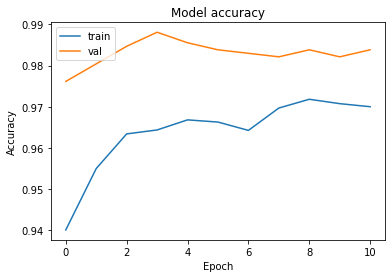

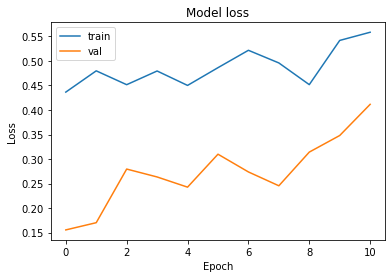

In [17]:
custom_model.compile(
    optimizer=Adam(learning_rate = 0.001) , 
    loss='categorical_crossentropy', 
    metrics = ['accuracy']
)

history = custom_model.fit(        
    train_generator,
    epochs = 30,
    validation_data=validation_generator,
    steps_per_epoch = train_size/BATCH_SIZE,
    callbacks = [es, mc]
)

plot_metrics_accuracy(history)
plot_metrics_loss(history)

As seen on the 11th epoch I got the accuracy of 98%. This represents how much power is included in transfer learning approach. Therefore, I decided to stop here to see the results in practice.

## 1.3. Results of transfer learning model using pretrained weghts of EfficientNet-B0

In [37]:
# load the saved model
saved_model = tf.keras.models.load_model('models/best_model_transf.h5')

def predict_class(img_url):
    img = imread(img_url)
    img = resize(img, IMG_SHAPE, preserve_range=True)
    img = tf.keras.applications.imagenet_utils.preprocess_input(img) # scale pixels between -1 and 1
    img = tf.expand_dims(img, axis = 0)
    prediction = saved_model.predict(img)
    print("CAT probability:", format(prediction[0][0],'.2f'))
    print("CHICKEN probability:", format(prediction[0][1],'.2f'))
    print("DOG probability:", format(prediction[0][2],'.2f'))

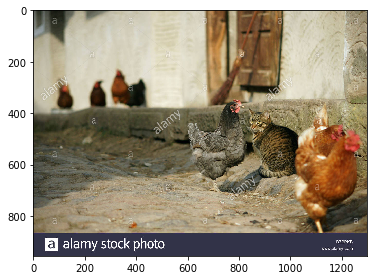

CAT probability: 0.44
CHICKEN probability: 0.56
DOG probability: 0.00


In [38]:
link = 'https://c8.alamy.com/comp/B7PPKB/colourful-cat-looking-at-passing-by-hen-in-front-of-old-farm-house-B7PPKB.jpg'
imshow(link)
plt.show()
predict_class(link)

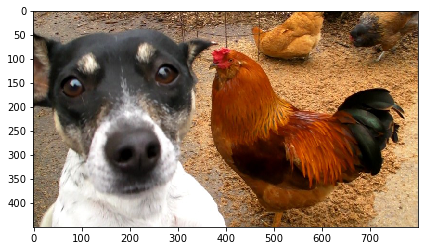

CAT probability: 0.00
CHICKEN probability: 0.00
DOG probability: 1.00


In [39]:
link = 'https://149366112.v2.pressablecdn.com/wp-content/uploads//2014/11/dogchick2.jpg'
imshow(link)
plt.show()
predict_class(link)

The result is good, on the first image where we see both cat and dog, the model succeded to see them as well with similar accuracy. However, on the second image the model didn't see a chicken. I think the reason for this is imbalanced train dataset, where I have ~2500 chicken images and ~4000 dog images. Therefore my model learned better how dogs look like. 

# 2. Convolutional autoencoders

## 2.1. Image denoising with Autoencoder

In this part I started with creating an autoencoder on the same dogs dataset with 4K images. However, after numerous experiments I've realised that train dataset metters a lot. Therefore I took a well-known dataset CIFAR-10 with 50K train size. 

In [3]:
data = tf.keras.datasets.cifar10.load_data()
data_train = data[0][0]
print(data_train.shape)
data_test = data[1][0]
print(data_test.shape)

data_train = data_train.astype('float32')/255.0
data_test = data_test.astype('float32')/255.0

# add noise to images
noise_factor = 0.2
data_train_noisy = data_train + noise_factor * tf.random.normal(shape=data_train.shape) 
data_test_noisy = data_test + noise_factor * tf.random.normal(shape=data_test.shape) 

data_train_noisy = tf.clip_by_value(data_train_noisy, clip_value_min=0., clip_value_max=1.)
data_test_noisy = tf.clip_by_value(data_test_noisy, clip_value_min=0., clip_value_max=1.)

(50000, 32, 32, 3)
(10000, 32, 32, 3)


In [40]:
LATENT_DIMENSION = 200
IMG_SHAPE = (32, 32)

Denoising_Autoencoder = Sequential([    
    
    Input((IMG_SHAPE[0], IMG_SHAPE[1], 3)),
    
    Conv2D(filters = 32, kernel_size = 3, padding = "same", activation = "relu"), # padding will add 2px frame
    BatchNormalization(),
    MaxPool2D(),
    
    Conv2D(filters = 32, kernel_size = 3, padding = "same", activation = "relu"), # padding will add 2px frame
    BatchNormalization(),    
    MaxPool2D(),
    
    Conv2D(filters = 64, kernel_size = 3, padding = "same", activation = "relu"), # padding will add 1px frame
    BatchNormalization(),    
    
    Conv2D(filters = 128, kernel_size = 3, padding = "same", activation = "relu"),

  
    Flatten(),
    Dense(LATENT_DIMENSION, activation='relu'),
    
    Dense(units=8*8*128, activation='relu'),
    
    Reshape((8, 8, 128)),
        
    Conv2DTranspose(filters = 128, kernel_size = 3, padding = "same", strides=1, activation = "relu"),
    BatchNormalization(),  
    
    Conv2DTranspose(filters = 64, kernel_size = 3, padding = "same", strides=1, activation = "relu"),
    BatchNormalization(),  
    
    Conv2DTranspose(filters = 32, kernel_size = 3, padding = "same", strides=2, activation = "relu"),
    BatchNormalization(),  
    
    Conv2DTranspose(filters = 3, kernel_size = 3, padding = "same", strides=2, activation = "relu") 

])
Denoising_Autoencoder.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_6 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 16, 16, 32)        9248      
_________________________________________________________________
batch_normalization_7 (Batch (None, 16, 16, 32)        128       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 8, 8, 64)         

Epoch 1/500
1563/1563 [==============================] - ETA: 0s - loss: 0.0659 - mse: 0.0659
Epoch 00001: val_loss did not improve from 0.04405
1563/1563 [==============================] - 15s 10ms/step - loss: 0.0659 - mse: 0.0659 - val_loss: 0.0488 - val_mse: 0.0488
Epoch 2/500
1557/1563 [============================>.] - ETA: 0s - loss: 0.0466 - mse: 0.0466
Epoch 00002: val_loss did not improve from 0.04405
1563/1563 [==============================] - 14s 9ms/step - loss: 0.0466 - mse: 0.0466 - val_loss: 0.0453 - val_mse: 0.0453
Epoch 3/500
1560/1563 [============================>.] - ETA: 0s - loss: 0.0441 - mse: 0.0441
Epoch 00003: val_loss improved from 0.04405 to 0.04263, saving model to ./models\best_model.h5
1563/1563 [==============================] - 14s 9ms/step - loss: 0.0440 - mse: 0.0440 - val_loss: 0.0426 - val_mse: 0.0426
Epoch 4/500
1562/1563 [============================>.] - ETA: 0s - loss: 0.0422 - mse: 0.0422
Epoch 00004: val_loss improved from 0.04263 to 0.04192

Epoch 29/500
1560/1563 [============================>.] - ETA: 0s - loss: 0.0372 - mse: 0.0372
Epoch 00029: val_loss did not improve from 0.03713
1563/1563 [==============================] - 14s 9ms/step - loss: 0.0372 - mse: 0.0372 - val_loss: 0.0371 - val_mse: 0.0371
Epoch 30/500
1557/1563 [============================>.] - ETA: 0s - loss: 0.0372 - mse: 0.0372
Epoch 00030: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00030: val_loss improved from 0.03713 to 0.03712, saving model to ./models\best_model.h5
1563/1563 [==============================] - 14s 9ms/step - loss: 0.0372 - mse: 0.0372 - val_loss: 0.0371 - val_mse: 0.0371
Epoch 31/500
1558/1563 [============================>.] - ETA: 0s - loss: 0.0369 - mse: 0.0369
Epoch 00031: val_loss improved from 0.03712 to 0.03686, saving model to ./models\best_model.h5
1563/1563 [==============================] - 14s 9ms/step - loss: 0.0369 - mse: 0.0369 - val_loss: 0.0369 - val_mse: 0.0369
Epoch 32/500
1557/15

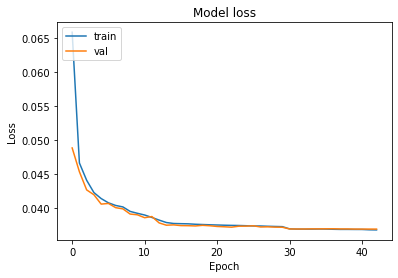

In [52]:
Denoising_Autoencoder.compile(
    optimizer=Adam(learning_rate = 0.001), 
    loss='mse', 
    metrics = ['mse']
)

da_history = Denoising_Autoencoder.fit(        
    x=data_train,
    y=data_train_noisy,
    batch_size=32,
    epochs = 500,
    shuffle = True,
    validation_data=(data_test, data_test_noisy),
    callbacks = [es_cb, lr_cb, mc_mse_cb] 
)

plot_metrics_loss(da_history)

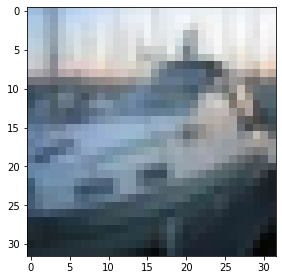

In [53]:
imshow(data_test[2])

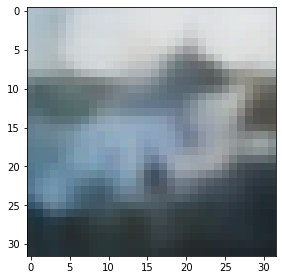

In [54]:
# load the saved model
saved_model = tf.keras.models.load_model('models/best_model.h5')
img = tf.expand_dims(data_test[2], axis = 0)
denoised_img = saved_model.predict(img)
imshow(tf.squeeze(denoised_img).numpy())

MSE achieved by the model is 0.036 and as seen the obtained result is not that good. There is still room for improvement.

I decided not to stop here but try to develop an unsupervised model which will generate images. I tried this model with CIFAR-10 dataset and 4K images dataset. Below is represented the result trained on 128x128 dog dataset.

## 2.2. Convolutional Variational Autoencoder for 128x128 images.

Convolutional Variational Autoencoder network turns the input samples x into two parameters in a latent space - **z_mean** and **z_log_var**. Then, we randomly sample similar points z from the latent normal distribution that is assumed to generate the data, via **z = z_mean + exp(z_log_var) * epsilon**, where **epsilon** is a random normal tensor. Finally, a decoder network maps these latent space points back to the original input data.

The parameters of the model are trained via two loss functions: a reconstruction loss forcing the decoded samples to match the initial inputs (just like in the previous autoencoder), and the KL divergence between the learned latent distribution and the prior distribution, acting as a regularization term. 

In [5]:
folder = './data/raw-img/dog'
data = load_images_from_folder(folder)
data.shape

(4863, 128, 128, 3)

In [55]:
def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [7]:
# Encoder

latent_dim = 500

input_img = Input(shape=(128, 128, 3))

conv = Conv2D(filters=32, padding='same', kernel_size=5, activation='relu')(input_img)

conv = Conv2D(filters=32, padding='same', kernel_size=5, strides=2, activation='relu')(conv)
conv = BatchNormalization()(conv)
# conv   = MaxPool2D()(conv)

conv = Conv2D(filters=64, padding='same', kernel_size=5, activation='relu')(conv)

conv = Conv2D(filters=64, padding='same', kernel_size=5, strides=2, activation='relu')(conv)

conv = BatchNormalization()(conv)

conv = Conv2D(filters=256, padding='same', kernel_size=5, strides=2, activation='relu')(conv)
# conv = Conv2D(filters=256, padding='same', kernel_size=3, strides=1, activation='relu')(conv)

conv = Conv2D(filters=512, padding='same', kernel_size=3, activation='relu')(conv)

conv   = MaxPool2D()(conv)

x = Flatten()(conv)
x = Dense(50, activation='relu')(x)
x = Dense(50, activation='relu')(x)
x = Dense(2 * latent_dim)(x)
x_split = tf.split(x, num_or_size_splits=2, axis=1, name='split')
z = Lambda(sampling, output_shape=(latent_dim,), name='z')(x_split)

For precise decoding of images from the latent space afterwards, we need implement a mirror to encoding part. That's why it is important to know Conv2D shape for Conv2DTranspose operation in decoder afterwards.

In [8]:
conv_shape = K.int_shape(conv)
conv_shape

(None, 8, 8, 512)

In [9]:
encoder = Model(
    input_img, 
    [x_split[0], x_split[1], z], 
    name='encoder')

encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 32) 2432        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 64, 64, 32)   25632       conv2d[0][0]                     
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 64, 64, 32)   128         conv2d_1[0][0]                   
____________________________________________________________________________________________

In [10]:
# decoder

input_gen = Input(shape=(latent_dim,))

y = Dense(50, activation='relu')(input_gen)
x = Dense(50, activation='relu')(x)

y = Dense(units=conv_shape[3] * conv_shape[2] * conv_shape[1], activation='relu')(input_gen)
y = Reshape((conv_shape[1], conv_shape[2], conv_shape[3]))(y)
y = BatchNormalization()(y)
# y = UpSampling2D()(y)

# here we use shape from the last conv. layer of the encoder
y = Conv2DTranspose(filters=512, kernel_size=5, strides=2, padding="same", activation='relu')(y)

y = Conv2D(filters=256, kernel_size=5, padding="same", activation='relu')(y)
y = BatchNormalization()(y)

y = Conv2DTranspose(filters=64, kernel_size=5, padding="same", strides=1, activation='relu')(y)
y = Conv2D(filters=64, kernel_size=5, padding="same", activation='relu')(y)
y = BatchNormalization()(y)
# y = UpSampling2D()(y)

y = Conv2DTranspose(filters=32, kernel_size=5, padding="same", strides=2, activation='relu')(y)
y = Conv2D(filters=32, kernel_size=5, padding="same", strides=1, activation='relu')(y)

y = Conv2DTranspose(filters=32, kernel_size=3, padding="same", strides=2, activation='relu')(y)
y = BatchNormalization()(y)

y = Conv2DTranspose(filters=3, kernel_size=3, strides=2, padding="same")(y)

In [81]:
decoder = Model(input_gen, y)
decoder.summary()

Model: "functional_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_23 (InputLayer)        [(None, 500)]             0         
_________________________________________________________________
dense_55 (Dense)             (None, 4096)              2052096   
_________________________________________________________________
reshape_18 (Reshape)         (None, 4, 4, 256)         0         
_________________________________________________________________
batch_normalization_156 (Bat (None, 4, 4, 256)         1024      
_________________________________________________________________
conv2d_transpose_101 (Conv2D (None, 8, 8, 64)          147520    
_________________________________________________________________
conv2d_144 (Conv2D)          (None, 8, 8, 64)          36928     
_________________________________________________________________
batch_normalization_157 (Bat (None, 8, 8, 64)        

In [12]:
output = decoder(encoder(input_img)[2])
vae = Model(input_img, output)
vae.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
encoder (Functional)         [(None, 500), (None, 500) 3464192   
_________________________________________________________________
functional_1 (Functional)    (None, 128, 128, 3)       26850499  
Total params: 30,314,691
Trainable params: 30,312,771
Non-trainable params: 1,920
_________________________________________________________________


The goal of VAE is to create the encodings, all of which are as close as possible to each other while still being distinct, allowing smooth interpolation, and enabling the construction of new samples.

This is where Kullback–Leibler divergence steps in. The KL divergence between two probability distributions simply measures how much they diverge from each other. Minimizing the KL divergence means optimizing the probability distribution parameters (μ and σ) to closely resemble that of the target distribution.

Moreover, we will use custom loss function - the sum of a reconstruction term (so the generated images are similar to the inputs), and the KL divergence regularization term (to get continuos samples from the decoder).

In [13]:
reconstruction_loss = mse(Flatten()(input_img), Flatten()(output))
reconstruction_loss *= 128*128

kl_loss = 1 + x_split[1] - K.square(x_split[0]) - K.exp(x_split[1])
kl_loss = K.sum(kl_loss, axis=1)
kl_loss = -0.5 * kl_loss

vae_loss = K.mean(reconstruction_loss + kl_loss)

vae.add_loss(vae_loss)
vae.compile(optimizer='adam')
vae.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
encoder (Functional)            [(None, 500), (None, 3464192     input_1[0][0]                    
__________________________________________________________________________________________________
functional_1 (Functional)       (None, 128, 128, 3)  26850499    encoder[0][2]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 32) 2432        input_1[0][0]                    
_______________________________________________________________________________________

In [14]:
log_dir = "./logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tb_cb = TensorBoard(
    log_dir=log_dir, 
    profile_batch=0)

es_cb = EarlyStopping(
    monitor='val_loss',
    verbose=True,
    patience=12,
    min_delta=0.0001, 
    restore_best_weights=True)

lr_cb = ReduceLROnPlateau(
    monitor='val_loss',
    verbose=True,
    patience=8,
    mi_delta=0.0001)

cb = [es_cb, lr_cb]

In [15]:
epochs = 200

autoencoder_train = vae.fit(
    x=data, 
    batch_size=100,
    epochs=epochs, 
    validation_split=0.1,
    shuffle=True,
#     validation_data=(validation_generator, None),
    callbacks=cb)

Epoch 1/200
44/44 [==============================] - 14s 315ms/step - loss: 4990.6987 - val_loss: 3742.1531
Epoch 2/200
44/44 [==============================] - 12s 268ms/step - loss: 2576.9197 - val_loss: 1992.5338
Epoch 3/200
44/44 [==============================] - 12s 268ms/step - loss: 1519.0610 - val_loss: 1537.8976
Epoch 4/200
44/44 [==============================] - 12s 263ms/step - loss: 1227.0089 - val_loss: 6068.0850
Epoch 5/200
44/44 [==============================] - 12s 264ms/step - loss: 850.3691 - val_loss: 4212.1787
Epoch 6/200
44/44 [==============================] - 12s 265ms/step - loss: 753.3103 - val_loss: 1604.2402
Epoch 7/200
44/44 [==============================] - 12s 264ms/step - loss: 724.8231 - val_loss: 1885.9934
Epoch 8/200
44/44 [==============================] - 12s 265ms/step - loss: 706.0911 - val_loss: 1977.9832
Epoch 9/200
44/44 [==============================] - 12s 269ms/step - loss: 687.0450 - val_loss: 858.1156
Epoch 10/200
44/44 [==============

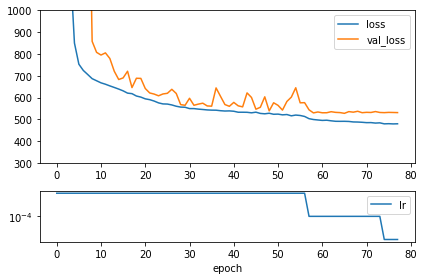

In [20]:
plot_loss_with_learning_rate(autoencoder_train)

In [21]:
n_examples = 16
examples = tf.random.normal(shape=[n_examples, latent_dim])
generated = decoder.predict(examples)

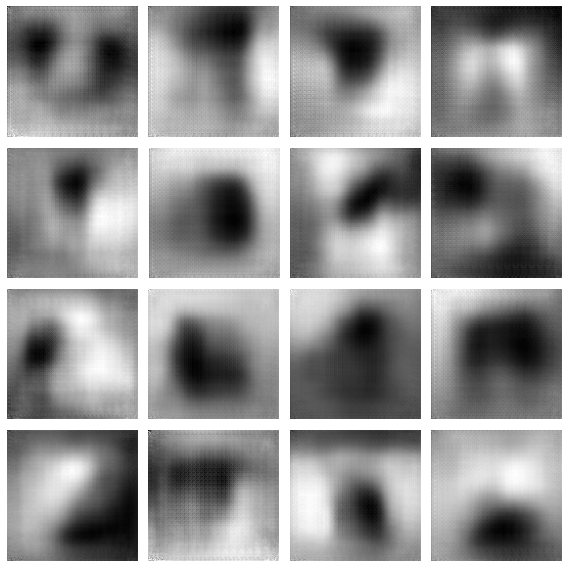

In [23]:
plt.figure(figsize=(8,8))
for i, gen in enumerate(generated):
    ax = plt.subplot(4, 4, i+1)
    plt.imshow(gen[:, :, 0], cmap='gray')
    ax.axis('off')
    plt.tight_layout()

The obtained results are not satisfied because of low model perfomance. The approach which should be used for VAE first of all using transfer learning from pretrained model which will be able to provide precise feature extraction. Afterwards, in decoding model I would place mirrored architecture of encoding model. By fine tuning of learning parameters the results should be much better. For the current model I have performed fine tuning of learning rate, batch size and latent dimensionality, which in some cases gave a slight better results but still blured as seen on the pictures above. But definitely training and tuning generative model takes much time and effort.

# Rerefencies

* [Tensorflow](https://www.tensorflow.org/tensorboard/hyperparameter_tuning_with_hparams)
* [Kaggle](https://www.kaggle.com/alessiocorrado99/animals10?select=raw-img)
* [How to do Transfer learning with Efficientnet](https://www.dlology.com/blog/transfer-learning-with-efficientnet/)
* [Building Autoencoders in Keras](https://blog.keras.io/building-autoencoders-in-keras.html)
* [GitHUB of ivanlen/autoencoders_safari](https://github.com/ivanlen/autoencoders_safari/blob/master/variational_convolutional_autoencoder.ipynb)
* [Convolutional Autoencoders for Image Noise Reduction](https://towardsdatascience.com/convolutional-autoencoders-for-image-noise-reduction-32fce9fc1763)
* [GitHUB Tensorflow/models](https://github.com/tensorflow/models/tree/master/research)
* [How to improve the model performance with Data Augmentation?](http://datahacker.rs/tf-data-augmentation/)
* [Use Early Stopping to Halt the Training of Neural Networks At the Right Time](https://machinelearningmastery.com/how-to-stop-training-deep-neural-networks-at-the-right-time-using-early-stopping/)
* [Intuitively Understanding Variational Autoencoders by Irhum Shafkat](https://towardsdatascience.com/intuitively-understanding-variational-autoencoders-1bfe67eb5daf)